# Introduction Data Science
# Assignment 3: Classification

In this assignment you will work with the "titanic" dataset and will use information over each passenger in prder to predict if he/she died or survived the shipwrek.

### Learning goals:
* Experiment with feature engineering (encoding, scaling, missing values)
* Use sklearn to implement a classification model
* Validate your model using cross-validation
* Generate predictions for a new dataset
* Prepare output of peredictions to submit it to Kaggle


###  Introduction: Kaggle Competition | Titanic Machine Learning from Disaster

>The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew.  This sensational tragedy shocked the international community and led to better safety regulations for ships.

>One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.  Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

>In this contest, we ask you to complete the analysis of what sorts of people were likely to survive.  In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

>This Kaggle Getting Started Competition provides an ideal starting place for people who may not have a lot of experience in data science and machine learning."

From the competition [homepage](http://www.kaggle.com/c/titanic-gettingStarted).


### Goal for this Notebook:
Show a simple example of an analysis of the Titanic disaster in Python using a full complement of PyData utilities. This is aimed for those looking to get into the field or those who are already in the field and looking to see an example of an analysis done with Python.

#### This Notebook will show basic examples of: 
#### Data Handling
*   Importing Data with Pandas
*   Cleaning Data
*   Exploring Data through Visualizations with Matplotlib

#### Data Analysis
*    Supervised Machine learning Techniques:
    +   Building classification models

#### Valuation of the Analysis
*   K-folds cross validation to valuate results locally
*   Output the results from the IPython Notebook to Kaggle

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from KaggleAux import predict as ka # see github.com/agconti/kaggleaux for more details
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, Imputer

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. Data preparation

### 1.1 Loading the data

In [9]:
df = pd.read_csv("../data/train.csv") 
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 1.2 Data exploration

#### 1.2.1 Missing values
There are several techniques to deal with missing values, but they will not be covered in this course. In this assinment we will use the simplest strategy possible: eliminate features with a big proportion of missing values and later eliminate all samples that still have missing values.

Perform the following steps:
1: Check the amount of missing values per feature
2: Drop columns with too many missing values
3: Drop all rows that have missing values in the remaining columns

* EXTRA: you can also try to fill in the missing values, check: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html

In [10]:
# 1. Check the amount of missing values per feature:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [11]:
# 2. Drop columns with too many missing values:
df = df.drop(['Ticket','Cabin'], axis=1)

# 3. Drop all rows that have missing values in the remaining columns:
df = df.dropna() 


### 1.2.2 Visualisation
It is very useful to get an idea about the relationship between each feature and the label you are trying to predict. A powerful tool to do that is by means of plots, such as histograms, barplots and boxplots, where you try to see if there is a difference in the distribution of the values of a certain feature accoring to the label. But be careful: the best plot depends on the type of the variable. Is the variable chategorical? Is it continuous? Numerical, but with just a couple of levels?

Perform the following steps:
1. Choose which variables you would like to plot.
2. Choose a type of plot for each variable.
3. Make the plot!
EXTRA: maybe the power in is the combination fo features? Think if a new feature that combines other features, plot it and check if your idea was correct. Tip: combination of 'Sex' and 'Pclass'

Reflection: looking at the plots, can you already identify which features areprobably useful to predict the label?


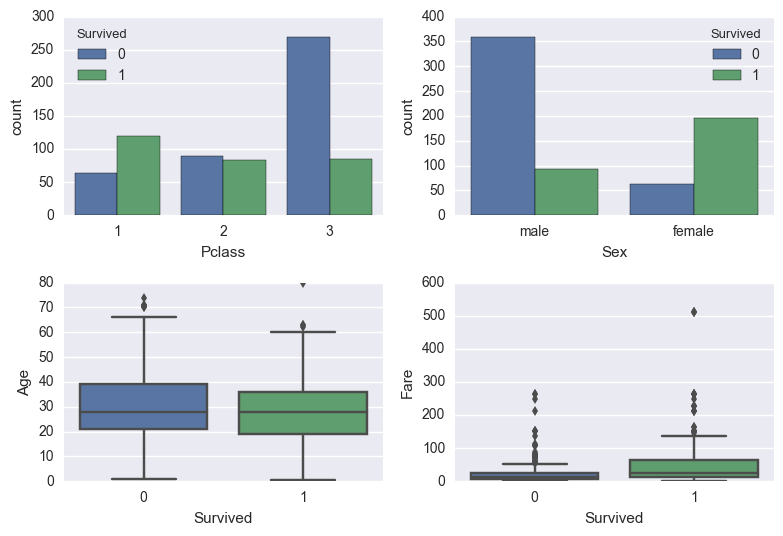

In [12]:
# Countplot of 'Pclass' and 'Sex':
fig = plt.figure()

idx = 0
for feature in ['Pclass','Sex']:
    ax = fig.add_subplot(2, 2, idx+1)
    sns.countplot(x=feature, data=df,hue='Survived')
    idx +=1

# Boxplot of violinplot of 'Age' and 'Fare'
for feature in ['Age','Fare']:
    ax = fig.add_subplot(2, 2, idx+1)
    sns.boxplot(data=df,x='Survived',y=feature)
    idx +=1
fig.tight_layout()



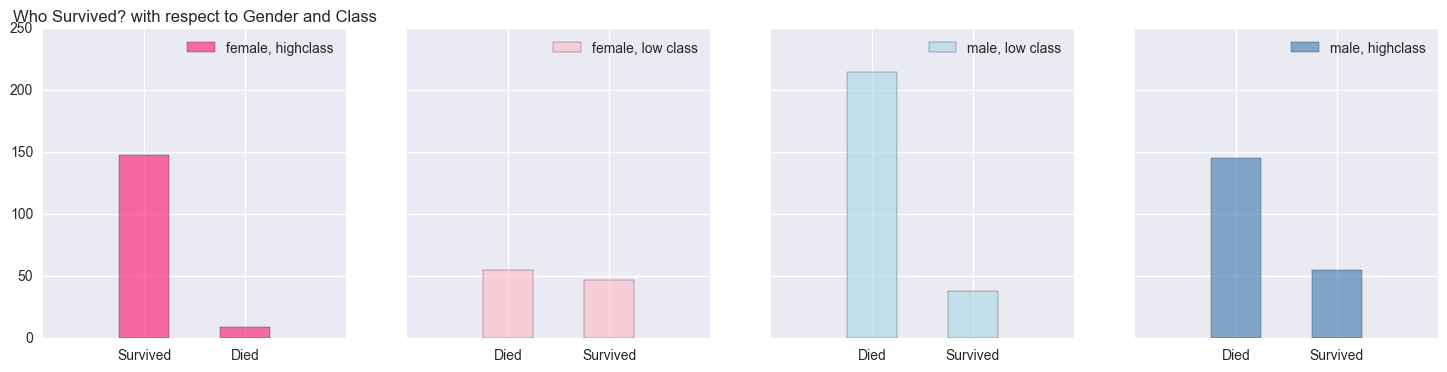

In [13]:
# Extra: 

fig = plt.figure(figsize=(18,4), dpi=1600)
alpha_level = 0.65

ax1=fig.add_subplot(141)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female, highclass', color='#FA2479', alpha=alpha_level)
ax1.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=alpha_level)
ax2.set_xticklabels(["Died","Survived"], rotation=0)
ax2.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
male_lowclass.plot(kind='bar', label='male, low class',color='lightblue', alpha=alpha_level)
ax3.set_xticklabels(["Died","Survived"], rotation=0)
ax3.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
male_highclass.plot(kind='bar', label='male, highclass', alpha=alpha_level, color='steelblue')
ax4.set_xticklabels(["Died","Survived"], rotation=0)
ax4.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')

### 1.2.3 Feature engineering

Categorical features have to be encoded before they are used in the model and the best way of encoding them depends of the feature itself.

We will start by encoding two features: 'Sex' and 'Embarked'.

Perform the following steps:
1. Start encoding 'Sex'. 
    * How many levels does it have? How should you encode it?
2. Encode 'Embarked'.
     * How many levels does it have? How should you encode it?

In [14]:
# 'Sex' has only two levels: so a good option is: female=0, male=1
df['Sex'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)

# 'Embarked' has 3 levels. If we encode them as 0,1,2, we imply that 
# there is an order between the levels and the model will try to learn from that. 
# In this case, we should use one hot econding then.
df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,S,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,S,0.0,0.0,1.0


## 2. Model
Now it is time to experiment with different classification models!

Attention points:
* Start by choosing one classifier (logistic regression, random forest?)
* Don't forget to start with a dummy classifier in order to have a baseline
* Use proper cross-validation  to make sure that you are not overfitting your training data. 
* For each model, use grid search in order to determine the best hyperparameters
* Think of scaling your data. Is it important in this case? If so, which technique should you use? And how do you implement it in a pipeline to make sure that there is no leakage between training and test sets in the cross-validation step?
* Thinking of using the structure of the sklearn pipeline (example here: http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html)

Perform the following steps:
1. Choose the feartures you will use in the model
2. From the dataframe, make X and y
3. Define your scaler (if any)
4. Choose the classifier to be used
5. Define the grid of hyperparameters
6. Perform grid search with cross-validation
7. Check which where the best hyperparameters and trian the final model in the whole training set
EXTRA: make predictions of the hold-out set to submit it to kaggle.

In [15]:
label = 'Survived'
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']
X = df.loc[:,features].values
y = np.array(df[label])
n_features = X.shape[1]


In [16]:
# Preprocessing steps:
scaler = StandardScaler(with_mean=True, with_std=True)
preproc_steps = [('my_scaler', scaler)]


model_type = 'rf'

# specification of different model types and their defaults


model_steps_dict = {'dummy': [('dummy', DummyClassifier(strategy='prior'))],
                    'lr': [('lr', LogisticRegression(C=0.001, penalty='l2', tol=0.01,
                                                     class_weight=None))],
                   'rf': [('rf', RandomForestClassifier(n_estimators=400, max_features='auto',
                                                       class_weight=None))]
                   }

# specification of the different model hyperparameters and tuning space
model_params_grid = {'dummy': {},
                    'lr': {'lr__C': [1e-4, 1e-3, 1e-2, 1e-1]},
                    'rf': {'rf__max_features': [3, 6, 9],
                           'rf__n_estimators': [10, 100, 1000]}
                     }

# store the model step
model_steps = model_steps_dict[model_type]

# combine everything in one pipeline
estimator = Pipeline(steps=(preproc_steps + model_steps))
print estimator

Pipeline(steps=[('my_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])


In [17]:
# Cross-validation:

k_cv = 5

grid_search = GridSearchCV(estimator, cv=k_cv,
                         param_grid=model_params_grid[model_type])

grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('my_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': [10, 100, 1000], 'rf__max_features': [3, 6, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [18]:
print('Best score: {}'.format(grid_search.best_score_))
print('\nBest parameters: {}'.format(grid_search.best_params_))
print('\nBest estimator: {}'.format(grid_search.best_estimator_))

Best score: 0.799157303371

Best parameters: {'rf__n_estimators': 1000, 'rf__max_features': 6}

Best estimator: Pipeline(steps=[('my_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])


In [19]:
# Final model:
model = grid_search.best_estimator_.fit(X, y)

### 3. EXTRA: Making predictions on the true test set + submission to Kaggle:
In the 'data' folder there is a file with unlabeled data: test.csv
You can use this file to make predictions and submit your results to kaggle.
Be careful: when working with a new dataset, make sure that you will preprocess it in the same way you did with the training data. And if there are missing values in the features used by your model, you need now to impute them in with information you have from your training set, otherwise you won't be able to make a prediction for all samples.

Perfom the following steps:
1. Load the data
2. Drop features 'Ticket','Cabin'
3. Check if there is still missing data. If so, how can you impute it? (tip 1: you can fill in the missing values with the average value of that feature in the training set. tip 2 (advanced): if you now that two features are very correlated (e.g. 'Plcass' and 'Fare'), you can use this information to make an informed-imputation (Fare|Pclass_1 = mean Fare on training set when Pclass=1)
4. Encode 'Gender' and 'Embarked'
5. Feature scaling (tip: use fit().transform())
6. Use model to make predictions
7. Generate output fro kaggle: dataframe with two columns: 'PassengerID' and 'Survided' (=prediction)

In [21]:
df_test = pd.read_csv('../data/test.csv')
print(df_test.shape)
print(df_test.isnull().sum())
df_test.head(2)

(418, 11)
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [22]:
# Drop features 'Ticket','Cabin'
df_test = df_test.drop(['Ticket','Cabin'], axis=1)

# Age: missing values = mean of 'Age' in the training set
df_test['Age'] = df_test['Age'].fillna(df['Age'].mean())

# Fare: missing values = mean w.r.t. 'Pclass':
fare_means = df.pivot_table('Fare', index='Pclass', aggfunc='mean')
df_test['Fare'] = df_test[['Fare', 'Pclass']].apply(lambda x:
                            fare_means[x['Pclass']] if pd.isnull(x['Fare'])
                            else x['Fare'], axis=1)

# Feature encoding for 'Gender' and 'Embarked'
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1}).astype(int)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Embarked'], prefix='Embarked')],
                axis=1)

In [23]:
# Selection of features + scaling
X_test = df_test.loc[:,features].values

X_test = scaler.fit(X).transform(X_test)


In [24]:
# Prediction:
output = model.predict(X_test)

In [25]:
# Output for kaggle:
result = np.c_[df_test.PassengerId.astype(int), output.astype(int)]

df_result = pd.DataFrame(result[:,0:2], columns=['PassengerId', 'Survived'])
# df_result.to_csv('../results/titanic_1-4.csv', index=False)
df_result

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
5,897,1
6,898,1
7,899,1
8,900,1
9,901,1
